In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [293]:
## Inspired by a question asked of me during a Google Quantitative Analyst interview, 
## this code implements a kernal nearest neighbors method to determine whether a given racial
## (geographic) distribution is significantly worse than a random distribution with the same population parameters
##
## Data input takes the form of a 3 x N list, whose rows contain [Latitude, Longitude, Race] where Race may take
## 1 of M values.  For this code we will represent 'Race' via an integer.
##
## Define a Class for cities, which will have functions which evaluate the segregation coefficient.  Allow the kernal
## to vary as defined by the user, with a default.
##
## The kernal applies to individuals who have the same race, weighted by distance.  If the data are clustered by race,
## The raw score will be higher than the randomized score, a ratio of 1 is no segregation
##
## It is shown below that we can conclude at very high levels of significance certain kinds of segregation (at least, others remain untested)
## The kernal may be adjusted at will
## Other improvements/tests:
## 1. The distance matrix calculator is the time limiting step operating at O([N**2]/d) where N is population and d the number of races
## 2. Have shown that the normalization accounts for global pop increases, have not tested nonuniform racial compositions
## 3. Have only tested one kind of segregation, others may give different results
## 4. Have not tested changing the size of the city, but the normalization **should** account for this
##
def random_generator(total_population=10**3,lat_extent=10**1,long_extent=10**1,num_races=2):
    output_data=[]  ##Generates a random population
    for i in range(total_population):
        individual=[np.random.rand()*lat_extent,np.random.rand()*long_extent,np.random.randint(num_races)]
        output_data.append(individual)
    return output_data
def lat_seg_generator(total_population=10**3,lat_extent=10**1,long_extent=10**1,num_races=2):
    output_data=[] #Generates a population which is segregated somewhat by latitude
    for i in range(total_population):
        individual=[np.random.rand()*lat_extent,np.random.rand()*long_extent]
        if individual[0]<.3*lat_extent:
            individual.append(np.random.randint(num_races-1))
        elif individual[0]>.7*lat_extent:
            individual.append(np.random.randint(num_races-1)+1)
        else:
            individual.append(np.random.randint(num_races))

        output_data.append(individual)
    return output_data

def gaussian_kernal(distance,sigma=20):
    return(np.exp(-distance**2/sigma**2))

def three_race_viewer(data_set):
    data_set=np.array(data_set)
    race1=[]
    race2=[]
    race3=[]
    for i in range(len(data_set)):
        if data_set[i,2]==0:
            race1.append(data_set[i])
        if data_set[i,2]==1:
            race2.append(data_set[i])
        if data_set[i,2]==2:
            race3.append(data_set[i])
    race1=np.array(race1)
    race2=np.array(race2)
    race3=np.array(race3)
    plt.figure(figsize=[20,10])
    plt.plot(race1[:,0],race1[:,1],'.',label='Race 1')
    plt.plot(race2[:,0],race2[:,1],'.',label='Race 2')
    plt.plot(race3[:,0],race3[:,1],'.',label='Race 3')
    plt.legend(fontsize=14)
    plt.show()
class City:
    def __init__(self,kernal=gaussian_kernal,input_data=[],total_population=10**3,num_races=2,lat_extent=10**1,long_extent=10**1):
        if input_data==[]:
            print("No data provided, initializing defaults")
            self.total_population=total_population #The total population of the city
            self.num_races=num_races               #Number of potential values for "race"
            self.lat_extent=lat_extent             #Lateral range of the city boundary
            self.long_extent=long_extent           #Longitudinal range of the city boundary
            self.kernal=kernal                     #Defines the default kernal
            self.data_set=np.array(random_generator(total_population,lat_extent,long_extent,num_races))
            
        else:                                      #Or determine these quantities automatically from a premade data set
            print("Input data loaded")
            self.total_population=len(input_data)
            input_data=np.array(input_data)
            self.num_races=int(np.max(input_data[:,2])+1)            
            self.lat_extent=np.max(input_data[:,0])
            self.long_extent=np.max(input_data[:,1])
            self.kernal=kernal
            self.data_set=np.array(input_data)
    def sort_data(self):
        self.data_set=self.data_set[np.argsort(self.data_set[:,2])]
    def randomize(self):
        np.random.shuffle(self.data_set[:,2])  #Produces a shuffled data set for normalization purposes
    def distance_matrices(self):
        self.sort_data()
        ## Need a key that says how many of each race we have.  Length is num_races, element i is the number or individuals with race i
        racelist=self.data_set[:,-1]
        race_key=np.bincount([int(i) for i in racelist]) #How many of each race there are
        boundary_indices=[]  #At which indices in data_set do we change races
        for i in range(len(race_key)):
            current_index=np.sum(race_key[:i])
            boundary_indices.append(current_index)
        D_matrix_stack=[] #Will be a stack of matrices as deep as num_races, each of which will be a pairwise distance matrix
        for k in range(len(race_key)):
            local_pop=race_key[k]  #The number of individuals of this race, sets dimensions of the matrix
            current_boundary_index=boundary_indices[k]
            D_matrix=np.zeros([local_pop,local_pop])  ### The i,j element of this matrix is the distance between the ith and jth elements of this racial subset
            for i in range(local_pop):                            ### If speed becomes an issue look here this is O(N**2)
                for j in range(i):
                    D_matrix[i,j]=np.linalg.norm(self.data_set[current_boundary_index+i,:2]-self.data_set[current_boundary_index+j,:2])
            D_matrix_stack.append(D_matrix)
        self.D_matrix_stack=D_matrix_stack
        return D_matrix_stack
    def evaluate_sum(self,D_matrix_stack):
        total=0
        for i in range(len(self.D_matrix_stack)):
            total+=np.sum(self.kernal(self.D_matrix_stack[i]))-.5*len(self.D_matrix_stack[i])**2 #Evaluate the kernal and subtract contributions from 0 entries
        return total
    def normalized_seg_score(self):
        self.distance_matrices()
        raw_seg_score=self.evaluate_sum(self.D_matrix_stack)
        self.randomize()
        self.distance_matrices()
        norm_seg_score=self.evaluate_sum(self.D_matrix_stack)
        #print("Normalized segregation score is "+str(np.round(raw_seg_score/norm_seg_score,4)))
        return(raw_seg_score/norm_seg_score)

Input data loaded
Normalized segregation score is 0.9483
Input data loaded
Normalized segregation score is 0.9684
Input data loaded
Normalized segregation score is 1.0062
Input data loaded
Normalized segregation score is 1.0898
Input data loaded
Normalized segregation score is 1.007
Input data loaded
Normalized segregation score is 1.0055
Input data loaded
Normalized segregation score is 1.0109
Input data loaded
Normalized segregation score is 1.0496
Input data loaded
Normalized segregation score is 1.0263
Input data loaded
Normalized segregation score is 1.0277
Input data loaded
Normalized segregation score is 1.0527
Input data loaded
Normalized segregation score is 0.9911
Input data loaded
Normalized segregation score is 1.028
Input data loaded
Normalized segregation score is 1.0231
Input data loaded
Normalized segregation score is 1.024
Input data loaded
Normalized segregation score is 0.9952
Input data loaded
Normalized segregation score is 1.0289
Input data loaded
Normalized segre

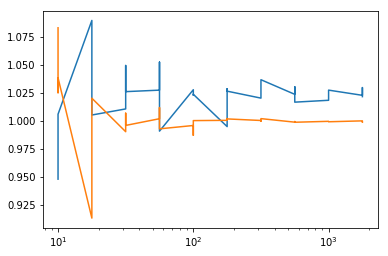

In [288]:
nseglist=[]
Nlist=[]
for ii in np.arange(0,2.5,.25):
    for l in range(3):
        Memphis=City(input_data=lat_seg_generator(int(10**(1+ii)),num_races=3))
        nseglist.append(Memphis.normalized_seg_score())
        Nlist.append(10**(1+ii))
plt.semilogx(Nlist,nseglist,'.')

nseglist=[]
Nlist=[]
for ii in np.arange(0,2.5,.25):
    for l in range(3):
        Memphis=City(input_data=random_generator(int(10**(1+ii)),num_races=3))
        nseglist.append(Memphis.normalized_seg_score())
        Nlist.append(10**(1+ii))
plt.semilogx(Nlist,nseglist,'.')

## This shows that for N> ~10**2, we can reliably identify the segregated case, and the scaling with 

In [296]:
nseglist_1=[]
nseglist_2=[]
for i in range(10):
    Memphis=City(input_data=lat_seg_generator(int(2*10**2),num_races=3))
    nseglist_1.append(Memphis.normalized_seg_score())
    Memphis=City(input_data=random_generator(int(2*10**2),num_races=3))
    nseglist_2.append(Memphis.normalized_seg_score())
print(np.mean(nseglist_1),np.std(nseglist_1))
print(np.mean(nseglist_2),np.std(nseglist_2))
print("The average measured city deviates from the null hypothesis by "+str((np.mean(nseglist_1)-np.mean(nseglist_2))/np.std(nseglist_2)))
#Here we see evidence that the measured differences are in fact statistically significant
#Given more data we could analyze cities with confidence our model would pick up on segregation

Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
Input data loaded
1.00879860332 0.00213515143968
0.999229391558 0.00120083813196
The average measured city deviates from the null hypothesis by 7.96877739986


In [290]:
(1.0265-1.0037)/.00666

3.423423423423413

In [120]:
xx=np.array(lat_seg_generator(4,num_races=10))
print(xx)
#np.random.shuffle(xx[:,2])
#print(xx)
print(xx.argsort())
print(xx)

[[ 0.71617162  0.85784325  7.        ]
 [ 8.94509235  0.78580014  8.        ]
 [ 9.34959854  0.32473638  2.        ]
 [ 2.67511062  2.19273669  6.        ]]
[[0 1 2]
 [1 2 0]
 [1 2 0]
 [1 0 2]]
[[ 0.71617162  0.85784325  7.        ]
 [ 8.94509235  0.78580014  8.        ]
 [ 9.34959854  0.32473638  2.        ]
 [ 2.67511062  2.19273669  6.        ]]


In [122]:
xx=xx[np.argsort(xx[:,2])]

In [137]:
xx=np.array(lat_seg_generator(10**3,num_races=3))
xx

array([[ 4.62558727,  8.5317958 ,  0.        ],
       [ 4.76481943,  8.33244023,  1.        ],
       [ 3.1704633 ,  0.93239502,  2.        ],
       ..., 
       [ 1.39237678,  8.63422821,  0.        ],
       [ 7.85840001,  8.66356315,  1.        ],
       [ 2.9555872 ,  4.66122001,  1.        ]])

In [131]:
np.bincount(int(xx[:,-1]))

TypeError: only length-1 arrays can be converted to Python scalars

In [138]:
rlist=xx[:,-1]
np.bincount([int(i) for i in rlist])

array([261, 470, 269])

In [147]:
xx=xx[np.argsort(xx[:,2])]
racelist=xx[:,-1]
race_key=np.bincount([int(i) for i in racelist]) #How many of each race there are
boundary_indices=[]  #At which indices in data_set do we change races
for i in range(len(race_key)):
    current_index=np.sum(race_key[:i])
    boundary_indices.append(current_index)


In [148]:
race_key

array([261, 470, 269])

In [145]:
boundary_indices

[0, 261, 731]

In [255]:
data_set=np.array(lat_seg_generator(10))
np.random.shuffle(data_set[:,2])  #Produces a shuffled data set for normalization purposes
print(shuffled_data)

None


In [260]:
np.random.shuffle(data_set[:,2])  #Produces a shuffled data set for normalization purposes

data_set

array([[ 4.24780178,  4.42428412,  0.        ],
       [ 4.44283447,  6.91096645,  1.        ],
       [ 4.89262601,  4.70204106,  1.        ],
       [ 6.99041687,  4.49506333,  1.        ],
       [ 1.19267968,  4.43624877,  1.        ],
       [ 9.5073692 ,  0.97334532,  0.        ],
       [ 7.90439966,  1.73793183,  1.        ],
       [ 2.0682237 ,  9.13958108,  0.        ],
       [ 9.88883575,  7.53355024,  0.        ],
       [ 3.68492087,  1.57887754,  1.        ]])